# Export Data for Web Application 

In [110]:
from cflp_function import cflp, plot_result, store_data_to_pickle, load_data_from_pickle, find_farm_not_in_solution_plant_in_solution
import pandas as pd
import numpy as np
import pydeck as pdk
import geopandas as gpd
import os

%matplotlib inline

In [111]:
# version_number = 6

### Load files and create parameters
* q_j max capacity of each j 
* f_j fixed cost of establishing each j
* set F set of farm locations
* set P set of potential digester locations
* C_ij transportation matrix 
* p_i 
* alpha
* mu

In [112]:
# Import farm_cluster_mock_5 dataset - which is the mock data for potential digester locations
potential_digester_location = pd.read_csv(r'./farm_cluster_mock_5.csv')
potential_digester_location.head()

,x,y,count
0,6.870686,52.215190,25
1,6.554937,52.254895,25
2,6.730518,52.252885,42
3,6.914234,52.387401,18
4,6.664105,52.392622,32


In [113]:
# Define the capacities of digester
medium_digester_capacity = 150560  # in tonne/yr
large_digester_capacity = 200000  # in tonne/yr

# Define the costs of digester 
medium_digester_cost = 252616   # in euro CAPEX
large_digester_cost = 12000000    # in euro CAPEX

In [114]:
potential_digester_location = potential_digester_location.drop(['count'], axis=1) # drop unnecessary column

In [115]:
# Create mock digester capacity data 
potential_digester_location['capacity'] = [medium_digester_capacity, medium_digester_capacity, large_digester_capacity, medium_digester_capacity, large_digester_capacity]

# Create mock digester cost data (f_j)
potential_digester_location['cost'] = [medium_digester_cost, medium_digester_cost, large_digester_cost, medium_digester_cost, large_digester_cost]

In [33]:
# (q_j)
max_capacity = potential_digester_location['capacity'].to_dict()    # Max_Supply = {'Fac-1' : 500, 'Fac-2' : 500, 'Fac-3' : 500}
# (f_j)
fixed_cost = potential_digester_location['cost'].to_dict()  # fixed_cost = {'Fac-1' : 1000, 'Fac-2' : 1000, 'Fac-3' : 1000 }

In [34]:
farm = pd.read_csv(r"./farm_mock.csv")
farm.head()

,Unnamed: 0,x,y,IND_OBJ_NA,manure_t,biogas_potential_m3
0,0,6.765843,52.314139,507920,2454,957060.0
1,1,6.837249,52.425084,507950,9827,3832530.0
2,2,6.859361,52.386225,507953,8660,3377400.0
3,3,6.753483,52.434382,507962,2913,1136070.0
4,4,6.484077,52.243620,507964,6488,2530320.0


In [45]:
# Lists (sets / Array) of Customers and Facilities
Farm = farm.index.tolist()  # set F
Plant = potential_digester_location.index.tolist() # set P

In [36]:
# (p_i)
manure_production = farm['manure_t'].to_dict()  

# Define the total manure production by all farms (alpha)
total_manure = sum(manure_production[i] for i in Farm)

In [11]:
# # Open the file for reading
# with open("./transportation_cost.txt", "r") as fp:
#     # Load the dictionary from the file
#     transport_cost = json.load(fp)

# # Function to recursively convert dictionary keys to integers
# def convert_keys_to_int(data):
#     if isinstance(data, dict):
#         return {int(key) if key.isdigit() else key: convert_keys_to_int(value) for key, value in data.items()}
#     else:
#         return data

# # Convert the keys to integers
# transport_cost = convert_keys_to_int(transport_cost) # C_ij

In [12]:
# for key, value in transport_cost.items():
#     print(f"{key}: {value}")

In [37]:
folder_path = 'app_data'

In [41]:
# Export files

# List
store_data_to_pickle(Farm, folder_path, 'Farm.pickle') # set F
store_data_to_pickle(Plant, folder_path, 'Plant.pickle') # set P

# Dictionary 
store_data_to_pickle(manure_production, folder_path, 'manure_production.pickle') # p_i 
store_data_to_pickle(max_capacity, folder_path, 'max_capacity.pickle') # q_j
store_data_to_pickle(fixed_cost, folder_path, 'fixed_cost.pickle') # f_j

# C_ij 

# Float
store_data_to_pickle(total_manure, folder_path, 'total_manure.pickle') # alpha

In [42]:
Farm = load_data_from_pickle(folder_path, 'Farm.pickle')
        # set P     set of potential digester locations
Plant = load_data_from_pickle(folder_path, 'Plant.pickle')
    # Dictionary 
        # p_i       manure production of each i
manure_production = load_data_from_pickle(folder_path, 'manure_production.pickle')
        # q_j       max capacity of each j 
max_capacity = load_data_from_pickle(folder_path, 'max_capacity.pickle')
        # f_j       fixed cost of establishing each j
fixed_cost = load_data_from_pickle(folder_path, 'fixed_cost.pickle')        
        # C_ij      transportation matrix 
transport_cost = load_data_from_pickle(folder_path, 'transportation_cost.pickle')
    # Float
        # alpha     total manure production
total_manure = load_data_from_pickle(folder_path, 'total_manure.pickle')
    # Float defined here
        # mu        manure utilization target 

## CFLP Model
* cflp: the cflp model
* find_farm_not_in_solution_plant_in_solution: disaggregating outputs for result visualization 
* plot_result: plot optimal solution (calls the previous function)

In [54]:
# Define manure use goal (mu)
target = 0.9

In [55]:
total_cost, total_fixed_cost, total_transport_cost, assignment_decision, use_plant_index = cflp(Plant, Farm, fixed_cost, transport_cost, manure_production, max_capacity, target, total_manure)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/ffa76c0b3a8249178bc830194337eebb-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/ffa76c0b3a8249178bc830194337eebb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 863 COLUMNS
At line 6564 RHS
At line 7423 BOUNDS
At line 8139 ENDATA
Problem MODEL has 858 rows, 715 columns and 3555 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.17228e+07 - 0.01 seconds
Cgl0008I 142 inequality constraints converted to equality constraints
Cgl0004I processed model has 858 rows, 857 columns (857 integer (857 of which binary)) and 3697 elements
Cbc0038I Initial state - 131 integers unsatisfied sum - 35.38

In [18]:
# # Check if the opened plants are under-utilized
# total_sum_list = [sum(farm.loc[i, 'manure_t'] for i in value) for value in assignment_decision.values()]

# potential_digester_location['allocated_manure'] = total_sum_list

# # Find the percentage of plant's capacity that is utilized
# potential_digester_location['underutilized'] = 0
# mask = potential_digester_location['allocated_manure'] > 0
# potential_digester_location.loc[mask, 'underutilized'] = (1 - (potential_digester_location.loc[mask, 'allocated_manure'] / potential_digester_location.loc[mask, 'capacity'])) * 100
# potential_digester_location

In [19]:
filename = f"./outputs/cflp_v{6}_{int(target*100)}%manure.png"  # You can choose the file extension (e.g., .png, .jpg, .pdf)

There are no duplicates in the list.


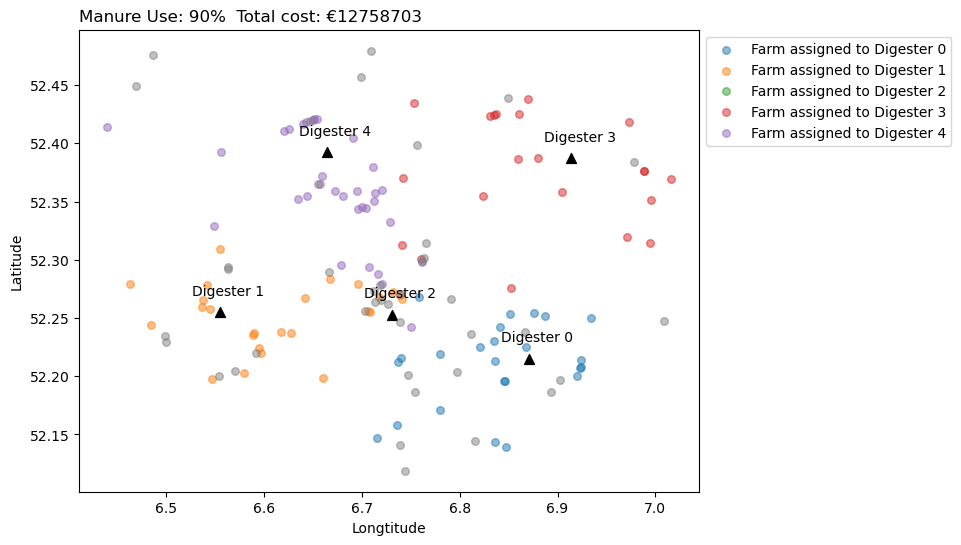

In [56]:
plot_result(Plant, potential_digester_location, assignment_decision, farm, Farm, use_plant_index, target, total_cost, filename, save_fig=False)

In [73]:
for key, value in assignment_decision.items():
    print(f"{key}: {value}")

0: [14, 16, 17, 18, 19, 20, 23, 27, 40, 43, 45, 75, 78, 79, 80, 82, 83, 84, 86, 88, 89, 90, 92, 131]
1: [4, 5, 6, 7, 24, 38, 41, 48, 50, 51, 53, 54, 56, 59, 60, 76, 77, 96, 97, 98, 119, 133, 137, 138, 139]
2: []
3: [1, 2, 3, 9, 12, 13, 21, 22, 30, 31, 33, 34, 57, 71, 73, 74, 99, 103, 104, 105, 141]
4: [25, 32, 49, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 93, 101, 106, 107, 108, 110, 111, 112, 113, 114, 118, 121, 128, 129, 130, 134, 135, 136, 140]


## Plot with PyDeck

In [59]:
os.environ["MAPBOX_API_KEY"]="sk.eyJ1Ijoid2VueXVjaGVuIiwiYSI6ImNscDZxZ2hpZzF0ejYyaXBicWs0YWZzb2kifQ.ReihW6LnhBUycKmcX_OIYQ"

In [136]:
import random
# Create a color mapping for digesters 
color_mapping = {label: [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)] for label in assignment_decision.keys()}

In [134]:
def get_plot_variables(assignment_decision, digester_df, farm, color_mapping):

    # Map digesters to colors
    digester_df['color'] = digester_df.index.map(color_mapping)

    # Map assigned farms to colors
    assigned_farms_df = farm[farm.index.isin([i for indices in assignment_decision.values() for i in indices])]
    assigned_farms_df['color'] = assigned_farms_df.index.map({index: color_mapping[digester] for digester, indices in assignment_decision.items() for index in indices})

    # Map unassigned farms to a default color (e.g., grey)
    unassigned_farms_df = farm[~farm.index.isin([index for indices in assignment_decision.values() for index in indices])]

    return digester_df, assigned_farms_df, unassigned_farms_df

In [137]:
digester_df, assigned_farms_df, unassigned_farms_df = get_plot_variables(assignment_decision, potential_digester_location, farm, color_mapping)

/var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/ipykernel_43480/3071834205.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assigned_farms_df['color'] = assigned_farms_df.index.map({index: color_mapping[digester] for digester, indices in assignment_decision.items() for index in indices})


In [83]:
# Map digesters to colors
potential_digester_location['color'] = potential_digester_location.index.map(color_mapping)

In [106]:
# Map assigned farms to colors
assigned_farms_df = farm[farm.index.isin([i for indices in assignment_decision.values() for i in indices])]

In [107]:
assigned_farms_df['color'] = assigned_farms_df.index.map({index: color_mapping[digester] for digester, indices in assignment_decision.items() for index in indices})

/var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/ipykernel_43480/2197995624.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assigned_farms_df['color'] = assigned_farms_df.index.map({index: color_mapping[digester] for digester, indices in assignment_decision.items() for index in indices})


In [100]:
# Map unassigned farms to a default color (e.g., grey)
unassigned_farms_df = farm[~farm.index.isin([index for indices in assignment_decision.values() for index in indices])]
# unassigned_farms_df['color'] = [[128, 128, 128]] * len(unassigned_farms_df)  # Grey color for unassigned farms

In [139]:
# Create a Pydeck layer for digesters
digesters_layer = pdk.Layer(
    type='ScatterplotLayer',
    data=digester_df,
    get_position=['x', 'y'],
    get_radius=1000,
    get_fill_color='color',
    pickable=True,
    auto_highlight=True
)

# Create a Pydeck layer for assigned farms
assigned_farms_layer = pdk.Layer(
    type='ScatterplotLayer',
    data=assigned_farms_df,
    get_position=['x', 'y'],
    get_radius=500,
    get_fill_color='color',
    pickable=True,
    auto_highlight=True
)

# Create a Pydeck layer for unassigned farms
unassigned_farms_layer = pdk.Layer(
    type='ScatterplotLayer',
    data=unassigned_farms_df,
    get_position=['x', 'y'],
    get_radius=500,
    get_fill_color=[128, 128, 128],
    pickable=True,
    auto_highlight=True
)

# Create a Pydeck deck
deck = pdk.Deck(
    layers=[digesters_layer, assigned_farms_layer, unassigned_farms_layer],
    initial_view_state=pdk.ViewState(
        latitude=potential_digester_location['y'].mean(),
        longitude=potential_digester_location['x'].mean(),
        zoom=8,
        pitch=0
    )
)

# Show the Pydeck Deck
deck.to_html("deck_trial_2.html")

In [67]:
layer = pdk.Layer(
    'ScatterplotLayer',     # Change the `type` positional argument here
    farm,
    get_position=['x', 'y'],
    auto_highlight=True,
    get_radius=1000,          # Radius is given in meters
    get_fill_color=[180, 0, 200, 140],  # Set an RGBA value for fill
    pickable=True)

# Set the center and zoom level based on the first digester's location
center = [farm.iloc[5].x, farm.iloc[5].y]
zoom = 8
# Create a Pydeck view state
view_state = pdk.ViewState(
    longitude=center[0],
    latitude=center[1],
    zoom=zoom,
)

# Create a Pydeck Deck
deck = pdk.Deck(
    layers=[layer],
    initial_view_state=view_state,
)

# Show the Pydeck Deck
deck.to_html("deck_trial.html")

In [68]:
# # Import Mapbox API Key from environment
# MAPBOX_API_KEY = os.environ["MAPBOX_API_KEY"]
 
# # AWS Open Data Terrain Tiles
# TERRAIN_IMAGE = "https://s3.amazonaws.com/elevation-tiles-prod/terrarium/{z}/{x}/{y}.png"
 
# # Define how to parse elevation tiles
# ELEVATION_DECODER = {"rScaler": 256, "gScaler": 1, "bScaler": 1 / 256, "offset": -32768}
 
# SURFACE_IMAGE = f"https://api.mapbox.com/v4/mapbox.satellite/{{z}}/{{x}}/{{y}}@2x.png?access_token={MAPBOX_API_KEY}"
 
# terrain_layer = pdk.Layer(
#     "TerrainLayer", elevation_decoder=ELEVATION_DECODER, texture=SURFACE_IMAGE, elevation_data=TERRAIN_IMAGE
# )
 
# view_state = pdk.ViewState(latitude=46.24, longitude=-122.18, zoom=11.5, bearing=140, pitch=60)
 
# r = pdk.Deck(terrain_layer, initial_view_state=view_state)

# # Show the Pydeck Deck
# r.to_html("terrain_layer.html")

In [69]:
# import folium

In [70]:
# for lat, long in zip(farm.y, farm.x):
#     folium.Marker(
#         location=[lat, long], 
#         icon=folium.Icon(icon_color='white')
#     ).add_to(map)

In [71]:
# center_map_coords = [52.40659843013704, 6.485187055207251]
# map = folium.Map(location=center_map_coords, zoom_start=10, tiles='OpenStreetMap')
# for lat, long in zip(farm.y, farm.x):
#     folium.Marker(
#         location=[lat, long], 
#         icon=folium.Icon(icon_color='white')
#     ).add_to(map)
# map